<a href="https://colab.research.google.com/github/maxiperezc/memoscopio/blob/master/HPC/cargaslibresGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install CUDA

In [2]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 13.1MB/s 
     |████████████████████████████████| 71kB 8.9MB/s 
     |████████████████████████████████| 81kB 10.3MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=620990 sha256=b3ff14b9e241a7d068184a5fb2a6307b235c1d05013c1bf360f2dfd9b74e0175
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=fe848d0d2a32ae7b5c82bf6132a6ee7291cb718ce401e17297fbced23ac8d50c
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


# Cargas Electricas Libres en 2D - GPU

Tiempo Total:  53.316 [ms]
Tiempo bucle:  53.148 [ms]


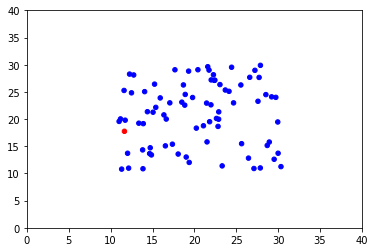

In [10]:
%matplotlib inline
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

import numpy
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from datetime import datetime


module = SourceModule("""
__global__ void kernel_newpos( int i, int j, float *X, float *Y )
{
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float dx;
  float dy;
  float rsq;
  float rrt;
  int ch;

  if( idx < i && idy < j && i != j){
    dx = X[idy] - X[idx];
    dy = Y[idy] - Y[idx];

    rsq = pow(dx,2) + pow(dy,2);
    rrt = rsq * sqrt(rsq);

    if(rrt > 1){
      ch = 1; //carga[i]*carga[j];
      X[idx] -= ch*dx/rrt;
      Y[idx] -= ch*dy/rrt;
    }
  }
}
""") 

tiempo_total = datetime.now()
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
tiempo_bucle = datetime.now()

positivas = 80
negativas = 1
numpoints = positivas + negativas
colores = ['blue'] * positivas + ['red'] * negativas 

def move():
  x_cpu  = numpy.random.uniform(10.0, 30.0, size=numpoints)
  y_cpu  = numpy.random.uniform(10.0, 30.0, size=numpoints)
  carga  = [1] * positivas + [-1] * negativas 
  vx_cpu = numpy.empty_like( x_cpu )
  vy_cpu = numpy.empty_like( y_cpu )

  x_gpu = cuda.mem_alloc( x_cpu.nbytes )
  y_gpu = cuda.mem_alloc( y_cpu.nbytes )
  cuda.memcpy_htod( x_gpu, x_cpu )
  cuda.memcpy_htod( y_gpu, y_cpu )

  #vx_gpu = cuda.mem_alloc( vx_cpu.nbytes )
  #vy_gpu = cuda.mem_alloc( vy_cpu.nbytes )
  #cuda.memcpy_htod( vx_gpu, vx_cpu )
  #cuda.memcpy_htod( vy_gpu, vy_cpu )

  kernel = module.get_function("kernel_newpos")

  dim_hilo_x = 16
  dim_bloque_x = numpy.int( (numpoints+dim_hilo_x-1) / dim_hilo_x )

  dim_hilo_y = 16
  dim_bloque_y = numpy.int( (numpoints+dim_hilo_y-1) / dim_hilo_y )

  while True:
    cuda.memcpy_htod( x_gpu, x_cpu )
    cuda.memcpy_htod( y_gpu, y_cpu )
    kernel( numpy.int32(numpoints), numpy.int32(numpoints), x_gpu, y_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )
    cuda.memcpy_dtoh( x_cpu, x_gpu )
    cuda.memcpy_dtoh( y_cpu, y_gpu )
    yield numpy.c_[x_cpu, y_cpu]

def update(i):
    data = next(stream)
    scat.set_offsets(data)
    return scat,

fig, ax = plt.subplots()
stream = move()
x, y = next(stream).T
scat = ax.scatter(x, y, c=colores, s=20, vmin=0, vmax=1)
ax.axis([0, 40, 0, 40])

anim = animation.FuncAnimation(fig, update, frames=numpy.arange(0, 1, 0.005), interval=100, blit=True, repeat=True)

# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')

tiempo_bucle = datetime.now() - tiempo_bucle
tiempo_total = datetime.now() - tiempo_total

print("Tiempo Total: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo bucle: ", tiempo_en_ms( tiempo_bucle ), "[ms]" )

anim
